 ![logo][gfzlogo]
 
 #   ENHANS -   Exposure modelling Workshop   -  May 2017
 
 ---
 
 
 ## 5.1 - Exploratory Data Analysis
 
 
 ---

 


[gfzlogo]:gfz_logo2.jpg

## language: Python 2.7

### first: Load packages

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from string import Template
import matplotlib.pyplot as plt
%matplotlib inline
#from lxml import etree
from sqlalchemy import create_engine
from sqlalchemy.sql import text

#used by the nrml 
NAMESPACE = 'http://openquake.org/xmlns/nrml/0.5'
GML_NAMESPACE = 'http://www.opengis.net/gml'
SERIALIZE_NS_MAP = {None: NAMESPACE, 'gml': GML_NAMESPACE}


# Query of building data from the database

the data is fetched from the database (either local or from remote) using a SQL query. 

In our case we retrieve the following information:

- latitude (of the centroid of the building)
- longitude (of the centroid of the building)
- ID of the building (same as used in the RRVS interface)
- mat_type: material type
- mat_tech: material technology
- mat_prop: material properties
- llrs: lateral load resisting system
- llrs_duct: ductility of the lateral load resisting system
- height: height, typology of observation
- height_1: height, value
- height_2: height, optional second value (for intervals)
- yr_built: year of construction
- occupy: type of occupancy
- occupy_dt: detail on the occupancy
- str_irreg: structural irregularities
- str_irreg_dt: detail on the structural irregularities
- str_irreg_type: type of structural irregularities
- roof_shape: shape of the roof
- roofcovmat: material of the roof cover
- roofsysmat: material of the roof structural system 
- roofsystyp: type of roof structural system
- roof_conn: type of roof connection
- floor_mat: material of the floors
- floor_type: type of the floors
- floor_conn: type of floors connection 

##Exercise 1
Query different attribute types from the database

##Exercise 2
Include a spatial query. Are boundary data defined ?

## create a connection to the database

In [2]:
engine = create_engine('postgresql://postgres@192.168.0.77:5432/rem')

## Query data, option 1: use the integrated view

In [5]:
# query to the database using the integrated modifiable view
def get_exp_full(engine,survey,status):
    
    sql = """
    select 
    st_x(st_transform(st_centroid(v.the_geom),4326)) lon,
    st_y(st_transform(st_centroid(v.the_geom),4326)) lat,
    v.*
    from asset.ve_object v where survey_gid={} and rrvs_status='{}';""".format(survey,status)

    t=pd.read_sql_query(sql,con=engine)
    return t

#test
tt = get_exp_full(engine, 2,'COMPLETED')

## Query data, option 2: use a 'crosstab'

In [6]:
# query to the database
def get_exp_raw(engine,survey,status):
    
    sql = """
select ct.*, oa.attribute_numeric_1 height_1  from crosstab(
   'select oa.object_id, oa.attribute_type_code, oa.attribute_value
    from asset.object_attribute as oa  order by 1,2;') 
    as ct(object_id integer,build_subtype varchar,
build_tpye varchar,
comment varchar,
floor_conn varchar,
floor_mat varchar,
floor_type varchar,
foundn_sys varchar,
height varchar,
height2 varchar,
llrs varchar,
llrs_duct varchar,
mat_prop varchar,
mat_tech varchar,
mat_type varchar,
nonstrcexw varchar,
occupy varchar,
occupy_dt varchar,
plan_shape varchar,
position varchar,
roof_conn varchar,
roof_covmat varchar,
rooof_shape varchar,
roof_sysmat varchar,
roofsystyp varchar,
rrvs_status varchar,
str_irreg varchar,
str_irreg_2 varchar,
str_irreg_dt varchar,
str_irreg_dt_2 varchar,
str_irreg_type varchar,
str_irreg_type_2 varchar,
vuln varchar,
yr_built varchar
), asset.object_attribute oa, asset.object o 
where oa.object_id = ct.object_id and oa.attribute_type_code='HEIGHT' 
and ct.rrvs_status='{}' and o.gid = ct.object_id and o.survey_gid={};
  """.format(status,survey)

    t=pd.read_sql_query(sql,con=engine)
    return t

#test
tt = get_exp_raw(engine, 7,'COMPLETED')

## Let´s have a look at the data

In [6]:
tt


,lon,lat,gid,survey_gid,description,source,accuracy,the_geom,object_id,mat_type,...,roofsysmat_src,roofsystyp_src,roof_conn_src,floor_mat_src,floor_type_src,floor_conn_src,foundn_sys_src,build_type_src,build_subtype_src,vuln_src
0,-76.877209,-12.032653,14494,2,None,FIELD,None,0106000020E6100000010000000103000000010000008B...,14494,MCF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-76.941304,-12.053251,14698,2,None,OSM,None,0106000020E61000000100000001030000000100000022...,14698,EU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-76.964167,-12.032852,14980,2,None,OSM,None,0106000020E61000000100000001030000000100000005...,14980,MCF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-76.963772,-12.032527,14981,2,None,OSM,None,0106000020E61000000100000001030000000100000005...,14981,MAT99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-76.918806,-12.025951,15087,2,None,OSM,None,0106000020E61000000100000001030000000100000005...,15087,E99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-76.919506,-12.026159,15088,2,None,OSM,None,0106000020E61000000100000001030000000100000005...,15088,MCF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-76.939484,-12.109550,15161,2,None,OSM,None,0106000020E61000000100000001030000000100000006...,15161,ME,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-76.945022,-12.061579,15194,2,None,OSM,None,0106000020E61000000100000001030000000100000005...,15194,C99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-76.945447,-12.060767,15195,2,None,OSM,None,0106000020E61000000100000001030000000100000005...,15195,MCF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-76.965057,-12.071198,15292,2,None,OSM,None,0106000020E61000000100000001030000000100000005...,15292,MAT99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Let us group the data based on 'material' and 'lateral load resisting system', what happens?

In [7]:
tt.groupby(['mat_type','llrs'])['object_id'].count().reset_index().sort_values('object_id',ascending=False)

,mat_type,llrs,object_id
13,MAT99,L99,19
19,MCF,LWAL,11
6,CR,LFM,8
1,C99,LFM,4
0,C99,L99,2
14,MAT99,LFM,2
20,ME,L99,2
5,CR,LDUAL,2
17,MCF,LDUAL,2
22,MR,LWAL,1


## Let´s increase the number of features in the grouping. What difference do we note? 

In [8]:
tt.groupby(['mat_type','mat_tech','mat_prop',
                  'llrs'])['object_id'].count().reset_index().sort_values('object_id',ascending=False)

,mat_type,mat_tech,mat_prop,llrs,object_id
21,MAT99,MATT99,MO99,L99,18
2,C99,CIPPS,MATP99,LFM,4
30,MCF,CLBRS,MOC,LWAL,3
24,MCF,CBS,MOC,LWAL,2
26,MCF,CIP,MON,LWAL,2
6,CR,CBS,MOC,LFM,2
7,CR,CIP,MATP99,LFM,2
10,CR,CIPPS,MO99,LFM,2
31,MCF,MR99,MOC,LWAL,1
25,MCF,CIP,MATP99,LFM,1


## Now we use six of the >30 features available

In [115]:
tt.groupby(['mat_type','mat_tech','mat_prop',
                  'llrs','llrs_duct','floor_mat'])['object_id'].count().reset_index().sort_values('object_id',ascending=False)

,mat_type,mat_tech,mat_prop,llrs,llrs_duct,floor_mat,object_id
20,MAT99,MATT99,MO99,L99,DU99,F99,45
53,MUR,MUN99,MO99,LO,DU99,FW,35
26,MR,RW,MO99,LH,DU99,FW,28
51,MUR,MUN99,MO99,LO,DU99,FC,21
52,MUR,MUN99,MO99,LO,DU99,FN,20
25,MR,RW,MO99,LH,DU99,FN,13
9,C99,CIP,MON,LO,DUC,FC,11
11,CR,CIP,MO99,LFINF,DUC,FC,11
64,W,WLI,MON,LO,DU99,FN,6
0,C99,CIP,MO99,LFINF,DUC,FC,5


## We can look at single features

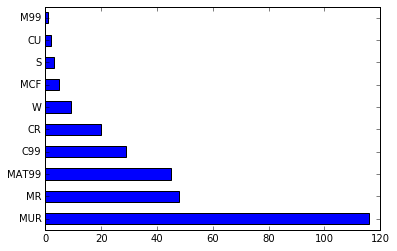

In [134]:
tt['mat_type'].value_counts().plot(kind='barh')

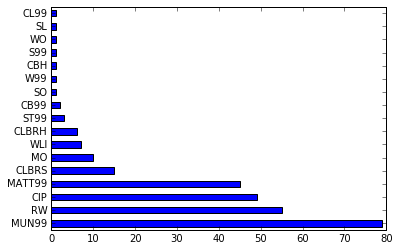

In [132]:
tt['mat_tech'].value_counts().plot(kind='barh')

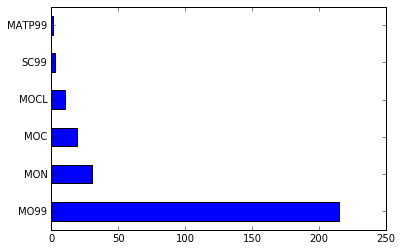

In [133]:
tt['mat_prop'].value_counts().plot(kind='barh')

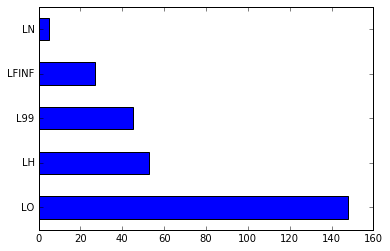

In [7]:
tt['llrs'].value_counts().plot(kind='barh')

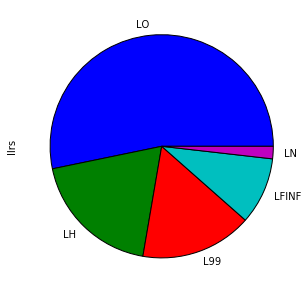

In [10]:
tt['llrs'].value_counts().plot(kind='pie',figsize=(5, 5))

## We can also analyze the correlation between pairs of variables

In [138]:
pd.crosstab(tt['mat_type'],tt['llrs'])

llrs,L99,LFINF,LH,LN,LO
mat_type,,,,,
C99,0,7,1,0,21
CR,0,20,0,0,0
CU,0,0,0,1,1
M99,0,0,1,0,0
MAT99,45,0,0,0,0
MCF,0,0,4,0,1
MR,0,0,43,0,5
MUR,0,0,4,2,110
S,0,0,0,0,3


In [155]:
pd.crosstab(tt['mat_type'],tt['llrs_duct'])

llrs_duct,DNO,DU99,DUC
mat_type,,,
C99,0,9,20
CR,0,1,19
CU,1,1,0
M99,0,1,0
MAT99,0,45,0
MCF,0,5,0
MR,0,48,0
MUR,3,113,0
S,1,1,1


## we can also investigate the relation between height (num storeys ) and other features 

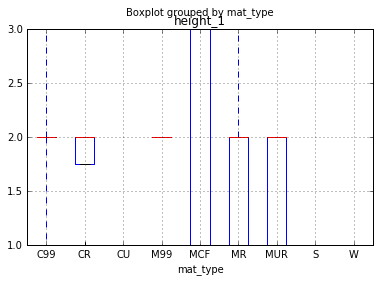

In [158]:
tt[tt['height_1']<99].boxplot('height_1',by='mat_type')

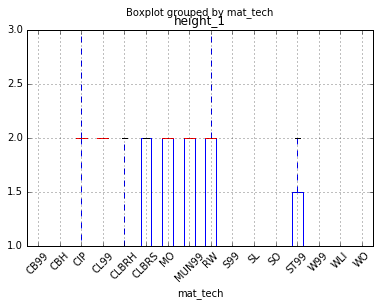

In [160]:
tt[tt['height_1']<99].boxplot('height_1',by='mat_tech',rot=45)



---



---

# Using boundary data

Boundary data provide a geographical support for aggregating the exposure model.

Boundary data can be:
- geographical (e.g. a continent, an isle)
- administrative (e.g. political borders, regions, districts, postal codes)
- abstract (geocell, regular grids)

Moreover, boundary data can nest into each other, therefore providing a natural multi-resolution support.

###How do we manage multiple boundary data in exposure modelling ?

In [41]:
# database connection
engine = create_engine('postgresql://postgres@localhost:5432/exposure_wb')

# query to the database, also include a list of table names specifying different boundary data layers.
# each boundary layer must include a geometry the_geom, a name name_en and an id object_id. 
def get_exp_bd(engine, tablename,boundaries):
    
    boundaries_pa=''
    boundaries_pb=''
    boundaries_pc=''
    
    for i,b in enumerate(boundaries):
        boundaries_pa += 'b{}.name_en name_b{},b{}.object_id id_b{},'.format(i,i,i,i)
        boundaries_pb += '{} b{},'.format(b,i)
        boundaries_pc += ' st_contains(b{}.the_geom,st_centroid(v.the_geom)) and'.format(i)
    
    sql = """
    select 
    st_x(st_transform(st_centroid(v.the_geom),4326)) lon,
    st_y(st_transform(st_centroid(v.the_geom),4326)) lat,
    v.the_geom,
    v.gid,
    v.e_bdgtype btype,
    {}
    from {} v, {} 
    where {}; """.format(boundaries_pa[:-1],tablename,boundaries_pb[:-1],boundaries_pc[:-3])
    
    #print sql
    
    t=pd.read_sql_query(sql,con=engine)
    return t

#test
tt = get_exp_bd(engine,'bdgs_est2',['boundary0','boundary1','boundary2'])

##Let us check how many different entries are present in each aggregation boundary. 

In [46]:
tt.groupby(['name_b0','name_b1','name_b2'])['btype'].value_counts()

name_b0     name_b1       name_b2          btype
kyrgyzstan  Batken        Batken-city      c4        52
                                           c1.3       6
                                           c2.4       2
                                           c1.1       1
                          Batkensky        c4       204
                                           c1.3      28
                                           c1.1       3
                                           c6         1
                          Kadamjaisky      c4       125
                                           c1.3      17
                                           c1.1       1
                                           c2.1       1
                          Kyzyl-Kiya-city  c4        62
                                           c1.3      37
                                           c3.1       2
                                           c1.1       1
                          Lyailyaksky      c4       229

## ... and write back the processed data into the database

In [168]:
#sql query to join the processed table with the information in the rrvs database
sqltempquery = Template('drop table if exists $tablename;\
create table $tablename as \
select v.*, p.btype \
from asset.ve_object v inner join $tablename_tmp p \
on v.object_id = p.object_id;\
drop table if exists $tablename_tmp;')

# function to export the processed building information to the database
def export_database(df, tablename):
    sql_pars=dict(tablename ='{}'.format(tablename),
                  tablename_tmp = '{}_tmp'.format(tablename))
    engine.execute(text("drop table if exists {};".format(sql_pars['tablename_tmp'])))
    df.to_sql(sql_pars['tablename_tmp'],engine)
    t = sqltempquery.substitute(sql_pars)
    engine.execute(text(t))

# create the processed table in the public schema of the database
export_database(expo_df,'proc_expo')

##Exercise
The resulting model can now be queried from the database and mapped using QGIS. Try this out!

